# 5. Modélisation avancée — Fine-tuning et interprétabilité (SHAP)

## Objectifs du notebook

Dans ce notebook, nous passons d’une phase de **baseline** à une phase de **modélisation stabilisée et interprétable**.

Les objectifs sont :
- optimiser les hyperparamètres du modèle retenu,
- valider la robustesse du modèle via validation croisée,
- analyser l’impact global des variables sur la prédiction,
- expliquer localement des décisions individuelles à l’aide de SHAP.

Ce notebook constitue le **cœur analytique** du projet, car il permet de relier performance prédictive et compréhension métier.


In [1]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("technova_attrition_grid_search")
mlflow.sklearn.autolog()

g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)


## Choix de la métrique d’optimisation

Le dataset étant déséquilibré, l’accuracy n’est pas une métrique adaptée.

Nous optimisons ici le modèle sur :
- **Average Precision (PR-AUC)**,

Cette métrique :
- se concentre sur la classe positive (départ),
- est plus informative que la ROC-AUC en cas de déséquilibre,
- est cohérente avec un objectif de détection des risques d’attrition.


In [26]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split

from technova_attrition.config import PATHS, SETTINGS
from technova_attrition.evaluation import (
    evaluate_classifier,
    find_threshold_for_recall,
    plot_precision_recall,
)
from technova_attrition.modeling import make_logreg, make_random_forest
from technova_attrition.preprocessing import FeatureGroups
from technova_attrition.tuning import run_grid_search, summarize_grid_search

df = pd.read_parquet(PATHS.data_processed / "employees_features.parquet")

TARGET = "a_quitte_l_entreprise"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=SETTINGS.random_state,
    stratify=y,
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SETTINGS.random_state)
y.value_counts(normalize=True).round(3)

a_quitte_l_entreprise
0    0.839
1    0.161
Name: proportion, dtype: float64

In [3]:
# === Numériques ===
num_cont = [
    "age",
    "augmentation_salaire_precedente",
    "distance_domicile_travail",
    "proba_chgt_experience_par_an",
    "proba_chgt_experience_par_an_adulte",
    "ratio_experience_vie_adulte",
]

num_log = [
    "revenu_mensuel",
    "annee_experience_totale",
    "annees_dans_l_entreprise",
    "annees_dans_le_poste_actuel",
    "annes_sous_responsable_actuel",
    "annees_depuis_la_derniere_promotion",
]

num_disc = [
    "nombre_participation_pee",
    "nb_formations_suivies",
    "nombre_employee_sous_responsabilite",
    "nombre_experiences_precedentes",
    "nombre_experiences_precedents",
]

# === Binaires ===
bin_cols = ["genre", "heure_supplementaires", "changement_poste"]

# === Nominales ===
cat_nom = ["statut_marital", "departement", "poste", "domaine_etude"]

# === Ordinales ===
cat_ord = [
    "satisfaction_employee_environnement",
    "satisfaction_employee_nature_travail",
    "satisfaction_employee_equipe",
    "satisfaction_employee_equilibre_pro_perso",
    "note_evaluation_precedente",
    "note_evaluation_actuelle",
    "niveau_hierarchique_poste",
    "niveau_education",
    "frequence_deplacement",
    "evolution_note",
]


# Nettoyage automatique : on ne garde que les colonnes présentes
def keep_existing(cols):
    return [c for c in cols if c in X.columns]


num_cont = keep_existing(num_cont)
num_log = keep_existing(num_log)
num_disc = keep_existing(num_disc)
bin_cols = keep_existing(bin_cols)
cat_nom = keep_existing(cat_nom)
cat_ord = keep_existing(cat_ord)

# Ordres ordinal : par défaut, on prend l’ordre trié (tu pourras le remplacer par un ordre métier explicite)
ord_categories = [sorted(df[c].dropna().unique().tolist()) for c in cat_ord]

groups = FeatureGroups(
    num_cont=num_cont,
    num_log=num_log,
    num_disc=num_disc,
    bin_cols=bin_cols,
    cat_nom=cat_nom,
    cat_ord=cat_ord,
    ord_categories=ord_categories,
)

groups

FeatureGroups(num_cont=['age', 'distance_domicile_travail', 'proba_chgt_experience_par_an', 'proba_chgt_experience_par_an_adulte', 'ratio_experience_vie_adulte'], num_log=['revenu_mensuel', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'annes_sous_responsable_actuel', 'annees_depuis_la_derniere_promotion'], num_disc=['nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'nombre_experiences_precedentes'], bin_cols=['genre', 'heure_supplementaires', 'changement_poste'], cat_nom=['statut_marital', 'departement', 'poste', 'domaine_etude'], cat_ord=['satisfaction_employee_environnement', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_precedente', 'note_evaluation_actuelle', 'niveau_hierarchique_poste', 'niveau_education', 'frequence_deplacement', 'evolution_note'], ord_categories=[[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2,

## Recherche d’hyperparamètres (GridSearch)

Nous utilisons un GridSearchCV pour :
- explorer un espace restreint mais pertinent d’hyperparamètres,
- éviter une recherche trop large difficile à interpréter,
- conserver une approche pédagogique et maîtrisée.

La recherche est effectuée :
- avec validation croisée stratifiée,
- en conservant les transformations dans le pipeline (pas de fuite de données).


In [4]:
logreg_pipe = make_logreg(groups)

param_grid_logreg = {
    "model__penalty": ["l2", "l1", "elasticnet"],
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__l1_ratio": [0.2, 0.5, 0.8],  # utilisé seulement si elasticnet
}

gs_logreg = run_grid_search(
    pipeline=logreg_pipe,
    param_grid=param_grid_logreg,
    X_train=X_train,
    y_train=y_train,
    cv=cv,
    scoring="average_precision",
    n_jobs=-1,
)

summary_logreg = summarize_grid_search(gs_logreg)
summary_logreg.head(10)

2026/01/04 17:33:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2900c6afafb14978b4731179290fa962', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2026/01/04 17:33:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1152: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l2 with l1_ratio=0.2. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
2026/01/04 17:35:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "g:\Mon Drive\OC\Proj

,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score,params
12,1,0.639470,0.020299,0.683176,0.012144,"{'model__C': 0.1, 'model__l1_ratio': 0.5, 'mod..."
15,1,0.639470,0.020299,0.683176,0.012144,"{'model__C': 0.1, 'model__l1_ratio': 0.8, 'mod..."
9,1,0.639470,0.020299,0.683177,0.012144,"{'model__C': 0.1, 'model__l1_ratio': 0.2, 'mod..."
18,4,0.634665,0.028518,0.685308,0.010779,"{'model__C': 1.0, 'model__l1_ratio': 0.2, 'mod..."
21,4,0.634665,0.028518,0.685308,0.010779,"{'model__C': 1.0, 'model__l1_ratio': 0.5, 'mod..."
24,4,0.634665,0.028518,0.685308,0.010779,"{'model__C': 1.0, 'model__l1_ratio': 0.8, 'mod..."
26,7,0.634340,0.031808,0.684642,0.010768,"{'model__C': 1.0, 'model__l1_ratio': 0.8, 'mod..."
23,8,0.634218,0.031649,0.684987,0.010963,"{'model__C': 1.0, 'model__l1_ratio': 0.5, 'mod..."
20,9,0.633890,0.030818,0.685404,0.010817,"{'model__C': 1.0, 'model__l1_ratio': 0.2, 'mod..."
11,10,0.633548,0.019735,0.678463,0.011971,"{'model__C': 0.1, 'model__l1_ratio': 0.2, 'mod..."


In [5]:
rf_pipe = make_random_forest(groups)

param_grid_rf = {
    "model__n_estimators": [300, 600],
    "model__max_depth": [None, 6, 10],
    "model__min_samples_leaf": [1, 5, 10],
    "model__max_features": ["sqrt", 0.5],
}

gs_rf = run_grid_search(
    pipeline=rf_pipe,
    param_grid=param_grid_rf,
    X_train=X_train,
    y_train=y_train,
    cv=cv,
    scoring="average_precision",
    n_jobs=-1,
)

summary_rf = summarize_grid_search(gs_rf)
summary_rf.head(10)

2026/01/04 17:36:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'edc4e36ce9d548148895432131eb93cc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2026/01/04 17:36:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


2026/01/04 17:36:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2026/01/04 17:36:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml en

,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score,params
1,1,0.561740,0.060186,1.000000,8.599751e-17,"{'model__max_depth': None, 'model__max_feature..."
33,2,0.555290,0.045485,0.961479,7.998223e-03,"{'model__max_depth': 10, 'model__max_features'..."
9,3,0.554822,0.045843,0.962974,8.775074e-03,"{'model__max_depth': None, 'model__max_feature..."
0,4,0.554794,0.060337,1.000000,1.216188e-16,"{'model__max_depth': None, 'model__max_feature..."
14,5,0.553949,0.050743,0.837578,4.327058e-03,"{'model__max_depth': 6, 'model__max_features':..."
27,6,0.553920,0.048601,0.927504,7.909099e-03,"{'model__max_depth': 10, 'model__max_features'..."
3,7,0.552230,0.047689,0.933373,8.716342e-03,"{'model__max_depth': None, 'model__max_feature..."
26,8,0.552087,0.053221,0.927256,8.508695e-03,"{'model__max_depth': 10, 'model__max_features'..."
2,9,0.550974,0.052306,0.932983,7.836552e-03,"{'model__max_depth': None, 'model__max_feature..."
15,10,0.550248,0.043167,0.838124,4.848144e-03,"{'model__max_depth': 6, 'model__max_features':..."


## Analyse des résultats du fine-tuning

À l’issue du GridSearch :
- nous comparons les scores moyens de validation,
- nous analysons la stabilité des performances,
- nous sélectionnons le modèle final sur la base :
  - du score,
  - de la variance,
  - de la cohérence métier des paramètres.

Un modèle légèrement moins performant mais plus stable et interprétable peut être préféré.


In [6]:
best_logreg = gs_logreg.best_estimator_
best_rf = gs_rf.best_estimator_

res_logreg = evaluate_classifier(best_logreg, X_train, y_train, X_test, y_test, threshold=0.5)
res_rf = evaluate_classifier(best_rf, X_train, y_train, X_test, y_test, threshold=0.5)

print("LogReg AP train:", res_logreg["train_ap"])
print("LogReg AP test:", res_logreg["test_ap"])
print("RF AP train:", res_rf["train_ap"])
print("RF AP test:", res_rf["test_ap"])
print("\nLogReg report:\n", res_logreg["test_report"])
print("\nRF report:\n", res_rf["test_report"])
print("\nLogReg confusion matrix:\n", res_logreg["test_cm"])
print("\nRF confusion matrix:\n", res_rf["test_cm"])

2026/01/04 17:37:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dc3ecd300ff84a68a44f19526f23accb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2026/01/04 17:37:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers 

LogReg AP train: 0.6872609660686652
LogReg AP test: 0.5992370642841178
RF AP train: 1.0
RF AP test: 0.37742326457090314

LogReg report:
               precision    recall  f1-score   support

           0      0.926     0.806     0.861       247
           1      0.392     0.660     0.492        47

    accuracy                          0.782       294
   macro avg      0.659     0.733     0.677       294
weighted avg      0.840     0.782     0.802       294


RF report:
               precision    recall  f1-score   support

           0      0.850     0.964     0.903       247
           1      0.357     0.106     0.164        47

    accuracy                          0.827       294
   macro avg      0.604     0.535     0.534       294
weighted avg      0.771     0.827     0.785       294


LogReg confusion matrix:
 [[199  48]
 [ 16  31]]

RF confusion matrix:
 [[238   9]
 [ 42   5]]


## Entraînement du modèle final

Une fois les hyperparamètres sélectionnés les métriques sont analysées au seuil métier retenu.

Cette étape permet de figer un modèle prêt à être interprété.


In [28]:
final_model = best_logreg
p_test = final_model.predict_proba(X_test)[:, 1]

plot_precision_recall(y_test, p_test)

thr = find_threshold_for_recall(y_test, p_test, target_recall=0.80)
thr

2026/01/04 17:45:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


0.3753087890724304

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
)

precision, recall, thr = precision_recall_curve(y_test, p_test)
ap = average_precision_score(y_test, p_test)

plt.figure()
plt.plot(recall, precision)
plt.title(f"Precision-Recall curve (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")

Text(0, 0.5, 'Precision')

In [8]:
res_thr = evaluate_classifier(final_model, X_train, y_train, X_test, y_test, threshold=thr)
print(res_thr["test_report"])
print(res_thr["test_cm"])

2026/01/04 17:37:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7e596770b9fc4581bce5b43b9f15cb3a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2026/01/04 17:37:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers 

              precision    recall  f1-score   support

           0      0.945     0.628     0.754       247
           1      0.292     0.809     0.429        47

    accuracy                          0.656       294
   macro avg      0.619     0.718     0.592       294
weighted avg      0.841     0.656     0.702       294

[[155  92]
 [  9  38]]


## Feature importance globale

L’interprétation globale vise à répondre à la question :
> « Quelles variables influencent le plus la probabilité de démission, en moyenne ? »

Nous utilisons SHAP pour :
- mesurer l’impact de chaque feature sur les prédictions,
- comparer l’importance relative des variables,
- analyser le sens des effets (augmentation ou diminution du risque).


In [9]:
from technova_attrition.explainability import permutation_importance_df

perm_df = permutation_importance_df(
    final_model, X_test, y_test, scoring="average_precision", n_repeats=20
)
perm_df.head(20)

g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,feature,importance_mean,importance_std
18,heure_supplementaires,0.238905,0.029682
13,satisfaction_employee_nature_travail,0.074419,0.019293
29,annees_depuis_la_derniere_promotion,0.064808,0.020078
7,annee_experience_totale,0.064800,0.033972
10,satisfaction_employee_environnement,0.060408,0.026373
6,nombre_experiences_precedentes,0.043873,0.013244
2,revenu_mensuel,0.029082,0.018525
14,satisfaction_employee_equipe,0.020412,0.014286
1,genre,0.016280,0.007578
25,distance_domicile_travail,0.015065,0.016451


In [10]:
perm_path = PATHS.reports / "permutation_importance.csv"
perm_df.to_csv(perm_path, index=False)
perm_path

WindowsPath('G:/Mon Drive/OC/Projet_4/technova_attrition/reports/permutation_importance.csv')

## Interprétation du Beeswarm Plot

Le Beeswarm Plot SHAP permet de visualiser :
- l’importance globale des features,
- la distribution des impacts,
- le sens des effets (valeurs élevées vs faibles).

Chaque point représente un individu :
- la position sur l’axe X indique l’impact sur la prédiction,
- la couleur représente la valeur de la feature.

Ce graphique est central pour extraire des insights métier.


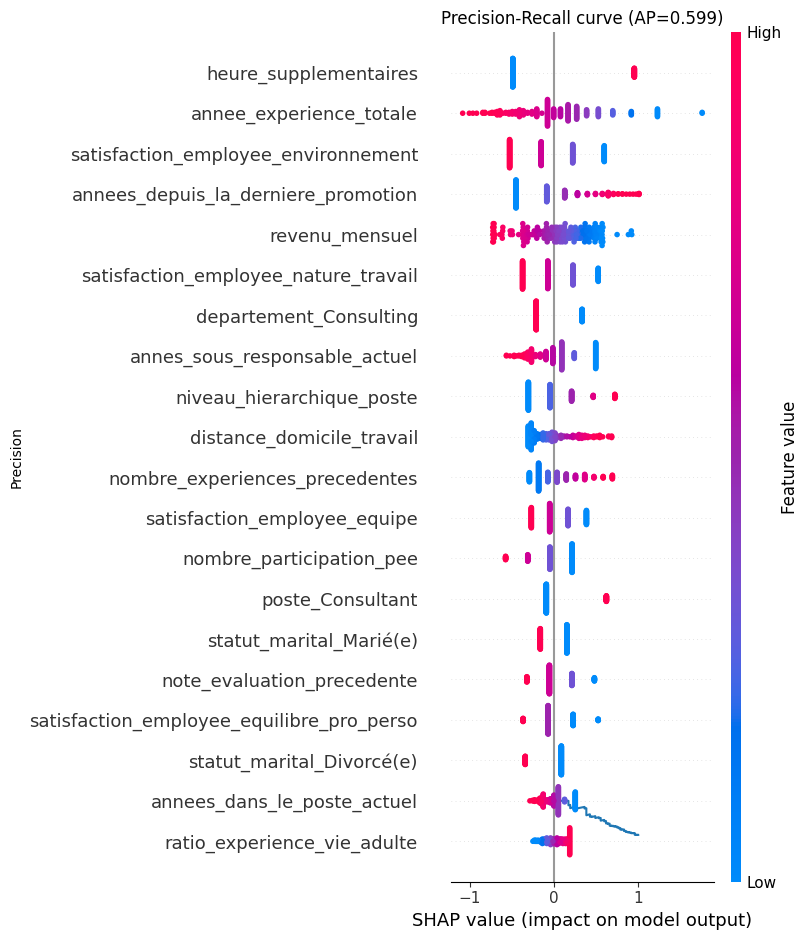

In [11]:
import shap

from technova_attrition.explainability import shap_explain_linear_model

# background = petit échantillon pour stabilité
X_bg = X_train.sample(min(200, len(X_train)), random_state=SETTINGS.random_state)
X_exp = X_test.sample(min(200, len(X_test)), random_state=SETTINGS.random_state)

explainer, shap_values, X_exp_t, feature_names = shap_explain_linear_model(final_model, X_bg, X_exp)

# Global beeswarm
shap.summary_plot(shap_values, X_exp_t, feature_names=feature_names)

## Analyse fine d’une variable — SHAP scatter plot

Le SHAP scatter plot permet d’analyser finement la relation entre :
- la valeur réelle d’une variable,
- son impact sur la prédiction (valeur SHAP),
- et ses interactions potentielles avec d’autres variables.

Chaque point représente un individu.
Ce graphique permet d’identifier :
- des effets non linéaires,
- des seuils critiques,
- des interactions implicites entre variables.


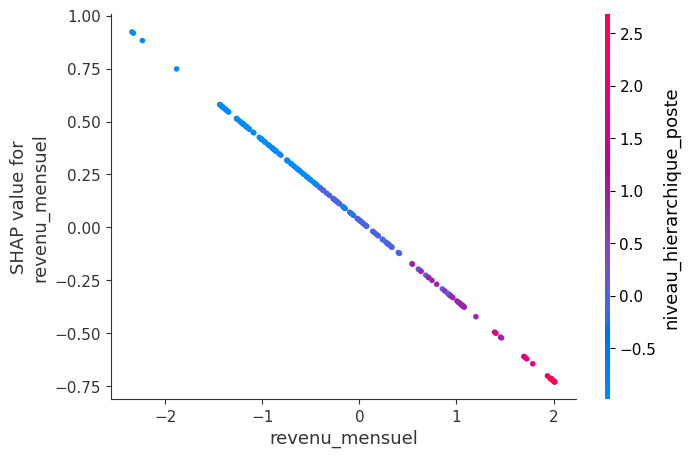

In [ ]:
feature = "revenu_mensuel"

# scatter SHAP "classique" (dependence plot)
shap.dependence_plot(
    feature,
    shap_values,  # array (n_samples, n_features)
    X_exp_t,  # array des features transformées (n_samples, n_features)
    feature_names=feature_names,
    interaction_index="auto",  # ou un nom de feature pour forcer l'interaction
)

## Interprétation locale des prédictions

L’interprétation locale permet de répondre à la question :
> « Pourquoi ce collaborateur est-il considéré comme à risque ? »

Elle est essentielle pour :
- expliquer une alerte RH,
- éviter des décisions arbitraires,
- dialoguer avec les managers ou les collaborateurs.


## Lecture d’un Waterfall Plot SHAP

Le Waterfall Plot montre :
- la prédiction moyenne du modèle,
- les contributions positives et négatives des features,
- la prédiction finale pour un individu donné.

Il permet de visualiser clairement :
- quels facteurs augmentent le risque de démission,
- quels facteurs le réduisent.


2026/01/04 18:23:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


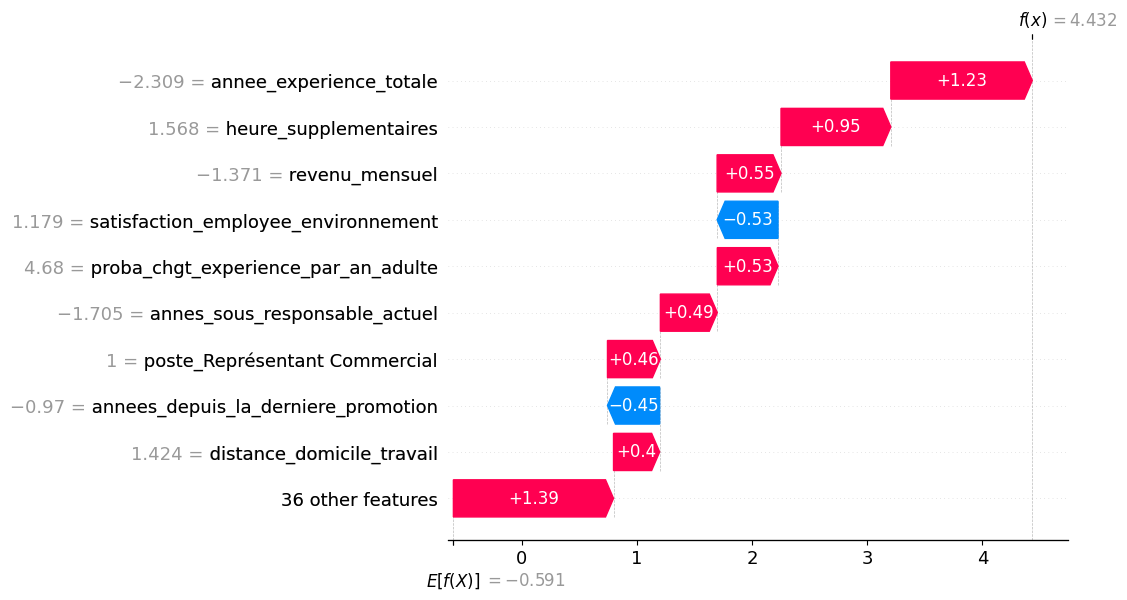

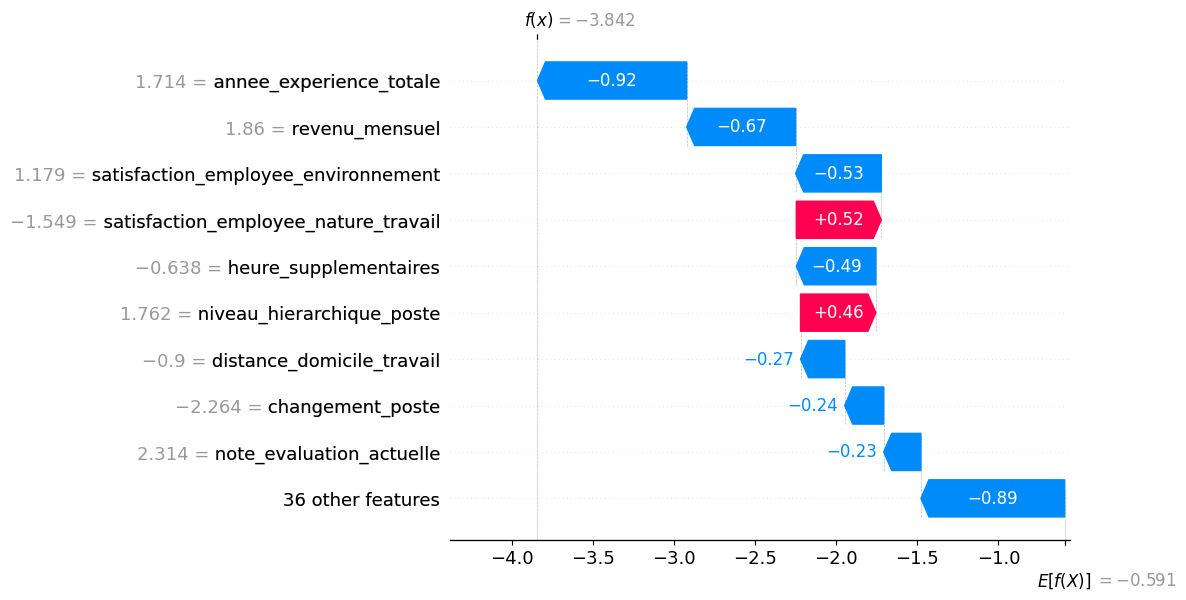

In [37]:
probas = final_model.predict_proba(X_test)[:, 1]
idx_high = probas.argmax()
idx_low = probas.argmin()

X_one_high = X_test.iloc[[idx_high]]
X_one_low = X_test.iloc[[idx_low]]

# Transform + shap values pour 1 point
Xb = X_bg
explainer, shap_vals_high, Xh_t, fn = shap_explain_linear_model(final_model, Xb, X_one_high)
explainer, shap_vals_low, Xl_t, fn = shap_explain_linear_model(final_model, Xb, X_one_low)

shap.plots.waterfall(
    shap.Explanation(
        values=shap_vals_high[0],
        base_values=explainer.expected_value,
        data=Xh_t[0],
        feature_names=fn,
    )
)
shap.plots.waterfall(
    shap.Explanation(
        values=shap_vals_low[0],
        base_values=explainer.expected_value,
        data=Xl_t[0],
        feature_names=fn,
    )
)

## Limites de l’interprétation

Il est important de rappeler que :
- SHAP explique le **modèle**, pas la réalité causale,
- les relations observées sont corrélationnelles,
- des biais présents dans les données peuvent se refléter dans le modèle.

Les résultats doivent donc être interprétés avec prudence et complétés par une expertise métier.


In [ ]:
import joblib

model_path = PATHS.models / "final_model.joblib"
joblib.dump(final_model, model_path)
model_path

WindowsPath('G:/Mon Drive/OC/Projet_4/technova_attrition/models/final_model.joblib')

## Conclusion du notebook

Ce notebook a permis :
- d’optimiser un modèle prédictif robuste,
- de valider ses performances de manière rigoureuse,
- d’identifier les principaux leviers d’attrition,
- d’expliquer des décisions individuelles de manière transparente.

Le modèle peut désormais être utilisé :
- comme outil d’aide à la décision,
- comme support d’analyse stratégique pour les équipes RH.

Les résultats devront être traduits en actions concrètes et validés par les parties prenantes métier.
